
## Dimensionality reduction

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.datasets import sdss_corrected_spectra
import seaborn as sns

from sklearn.manifold import LocallyLinearEmbedding, Isomap, SpectralEmbedding

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn import manifold, neighbors

from scipy.sparse.csgraph import laplacian as csgraph_laplacian
import scipy.spatial as spt
from scipy.sparse.linalg import eigsh, eigs

from umap import UMAP

random_state = 42
np.random.seed(random_state)

#### Application of PCA

For our astronomy use case, we are using the SDSS spectroscopic dataset. 
The SDSS spectra come from galaxies at a range of redshifts,
and have sections of unreliable or missing data due to sky absorption, cosmic rays, bad detector pixels,
or other effects. AstroML provides a set of spectra which have been moved to rest frame, corrected
for masking using an iterative PCA reconstruction technique, and resampled to 1000 common wavelength bins. 

The spectra can be downloaded using `fetch_sdss_corrected_spectra()`. In the following example we plot
15 of these spectra:

In [3]:
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
y = data['lineindex_cln']

# lookup for classes, 0-6
cdict = ['unknown', 'star', 'absorption galaxy',
         'galaxy', 'emission galaxy',
         'narrow-line QSO', 'broad-line QSO']


In [4]:

#----------------------------------------------------------------------
# Use pre-computed PCA to reconstruct spectra
spectra_raw = data['spectra']
spectra_corr = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

#------------------------------------------------------------
# select random spectra
nrows = 5
ncols = 3
ind = np.random.randint(spectra_corr.shape[0], size=nrows * ncols)
spec_sample_raw = spectra_raw[ind]
spec_sample_corr = spectra_corr[ind]

We show the SDSS downloaded spectra with black, and our corrected spectra with blue.

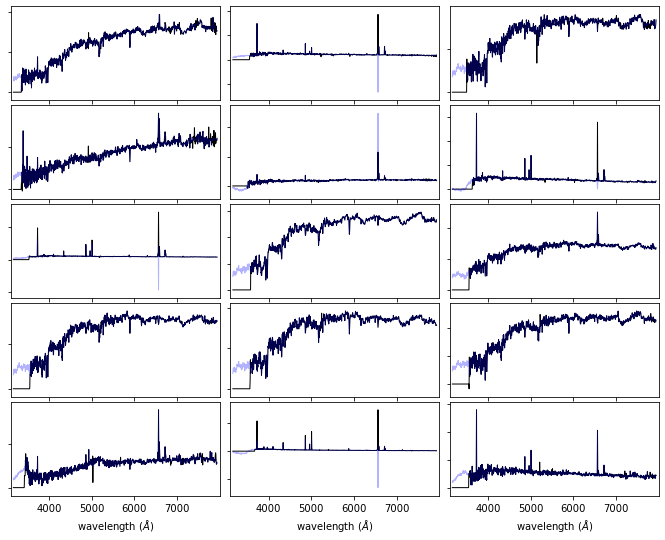

In [5]:
fig = plt.figure(figsize=(10, 8))

fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

for i in range(ncols):
    for j in range(nrows):
        ax = fig.add_subplot(nrows, ncols, ncols * j + 1 + i)
        ax.plot(wavelengths, spec_sample_raw[ncols * j + i], '-k', lw=1)
        ax.plot(wavelengths, spec_sample_corr[ncols * j + i], '-b', lw=1, alpha=0.3) # , c='blue')               
        ax.set_xlim(3100, 7999)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < nrows - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            plt.xlabel(r'wavelength $(\AA)$')

        ylim = ax.get_ylim()
        dy = 0.05 * (ylim[1] - ylim[0])
        ax.set_ylim(ylim[0] - dy, ylim[1] + dy)

plt.show()

### PCA Reconstruction of a spectrum

Reconstruction of spectrum, ${x}(k)$, from the
eigenvectors, ${e}_i(k)$ 

$$  {x}_i(k) = {\mu}(k) + \sum_j^R \theta_{ij} {e}_j(k),$$

Truncating this expansion (i.e., $r<R$)

$$
{x}_i(k) = {\mu}(k) + \sum_i^{r<R} \theta_i {e}_i(k),
$$

- eigenvectors ordered by their associated eigenvalues 
- eigenvalues reflect variance  within each eigenvector (sum of the eigenvalues is total variance of the system).
- project a each spectrum onto these first few eigenspectra is a compression of the data 

This is the sense in which PCA gives for dimensionality reduction.

In the following example, the input spectrum is shown in gray,
and the partial reconstruction for progressively more terms is shown in black. 
The top panel shows only the mean of the set of spectra. By the time 20 PCA components are added,
the reconstruction is very close to the input, as indicated by the expected total variance of 94%.

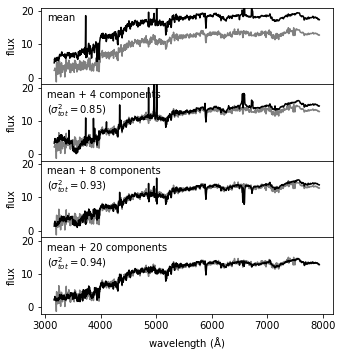

In [6]:
#------------------------------------------------------------
# Compute PCA components
#  because the spectra have been reconstructed from masked values, 
#  we'll use the values computed
#  in the file compute_sdss_pca.py
evals = data['evals'] ** 2
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]
evecs = data['evecs']
spec_mean = spectra_corr.mean(0)

#------------------------------------------------------------
# Find the coefficients of a particular spectrum
spec = spectra_corr[1]
coeff = np.dot(evecs, spec - spec_mean)

#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

for i, n in enumerate([0, 4, 8, 20]):
    ax = fig.add_subplot(411 + i)
    ax.plot(wavelengths, spec, '-', c='gray')
    ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-k')

    if i < 3:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.set_ylim(-2, 21)
    ax.set_ylabel('flux')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component\n"
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
    else:
        text = "mean + %i components\n" % n
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

    ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

### Eigenvalues

The eigenvalues for the PCA decomposition of the SDSS spectra described in the previous section. The top panel
shows the decrease in eigenvalue as a function of the number of eigenvectors, with a break in the distribution
at ten eigenvectors. The lower panel shows the cumulative sum of eigenvalues normalized to unity. 
94% of the variance in the SDSS spectra can be captured using the first ten eigenvectors.

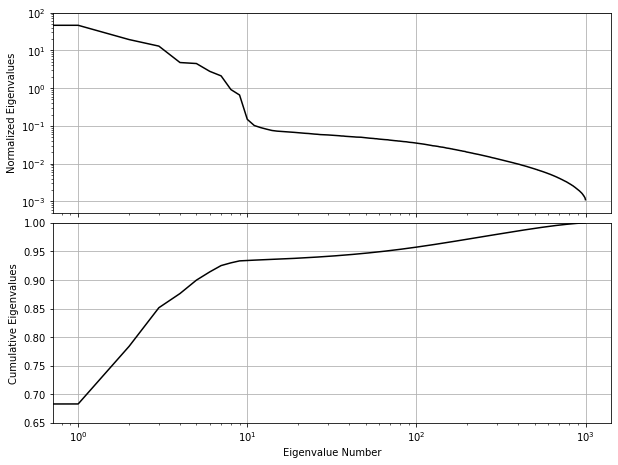

In [7]:
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(hspace=0.05, bottom=0.12)

ax = fig.add_subplot(211, xscale='log', yscale='log')
ax.grid()
ax.plot(evals, c='k')
ax.set_ylabel('Normalized Eigenvalues')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylim(5E-4, 100)

ax = fig.add_subplot(212, xscale='log')
ax.grid()
ax.semilogx(evals_cs, color='k')
ax.set_xlabel('Eigenvalue Number')
ax.set_ylabel('Cumulative Eigenvalues')
ax.set_ylim(0.65, 1.00)

plt.show()

## Comparing LLE, ISOMAP, UMAP

In [ ]:
def get_eigenvalues(X, n_neighbours, n_clusters):
    """ Helper function that will construct a nearest neighbours
    similarity graph from X, then compute a normalised Laplacian for this graph,
    and then calculate the smallest n_clusters eigenvalues.
    
    This is useful for identifying the number of clusters expected
    in the data when using SpectralEmbedding
    """
    K = kneighbors_graph(X, n_neighbors=n_neighbours, include_self=True)

    K = 0.5 * (K + K.T)


    # diagonal matrix
    L, D = csgraph_laplacian(
            K, normed=True, return_diag=True
        )

    L = L.tocoo()
    diag_idx = L.row == L.col
    L.data[diag_idx] = 1
    # If the matrix has a small number of diagonals (as in the
    # case of structured matrices coming from images), the
    # dia format might be best suited for matvec products:
    n_diags = np.unique(L.row - L.col).size
    if n_diags <= 7:
        # 3 or less outer diagonals on each side
        L = L.todia()
    else:
        # csr has the fastest matvec and is thus best suited to
        # arpack
        L = L.tocsr()

    L *= -1
    vals, vecs = eigsh(
        L, k=n_clusters, sigma=1.0, which="LM", tol=1e-5
    )

    # sort these based on the eigenvalues
    vecs = vecs[:,np.argsort(vals)]
    vals = vals[np.argsort(vals)]
    plt.plot(vals)
    
    return vecs, vals


def plot_2d(X, labels, title):
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.jet)
    plt.xlabel('coefficient 1')
    plt.ylabel('coefficient 2')
    plt.title(title)
    
    

def mask_outliers(X):
    BT = neighbors.BallTree(X)
    dist, ind = BT.query(X, 10)
    dist_to_n = dist[:, -1]
    dist_to_n -= dist_to_n.mean()
    std = np.std(dist_to_n)
    flag = (dist_to_n > 0.25 * std)
    print(" - removing {0} outliers for plot".format(flag.sum()))
    return flag

### Isomap

In [ ]:
iso = Isomap(n_components=IMPLEMENT_ME, n_neighbors=IMPLEMENT_ME)

ISOMAP_PROJECTION = IMPLEMENT_ME

plot_2d(ISOMAP_PROJECTION, y, 'ISOMAP projection of Spectra')

### UMAP


In [336]:
umap_obj = UMAP(
    n_components=IMPLEMENT_ME, 
    metric="euclidean",
    n_neighbors=IMPLEMENT_ME, 
    min_dist=IMPLEMENT_ME,
    random_state=random_state
)


UMAP_PROJECTION = IMPLEMENT_ME

plot_2d(UMAP_PROJECTION, y, 'UMAP projection of Spectra')

### Spectral Embedding

In [ ]:
se = SpectralEmbedding(n_components=IMPLEMENT_ME, n_neighbors=IMPLEMENT_ME, random_state=random_state) 

SE_PROJECTION = IMPLEMENT_ME

plot_2d(SE_PROJECTION, y, 'SpectralEmbedding projection of Spectra')

### LLE

In [ ]:
lle = LocallyLinearEmbedding(n_components=IMPLEMENT_ME, n_neighbors=IMPLEMENT_ME, method='modified', eigen_solver='dense', random_state=random_state) 

LLE_PROJECTION = IMPLEMENT_ME

# Note: the LLE projection has some outliers that can make the plot
# look weird.  Use the following to find the mask to remove the outliers
# for the plot
flag = mask_outliers(LLE_PROJECTION)


plot_2d(LLE_PROJECTION[~flag], y[~flag], 'LLE projection of Spectra')